In [3]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.10.1 | packaged by conda-forge | (main, Dec 22 2021, 01:39:05) [GCC 9.4.0]
pjr3.py complete


In [4]:
print ("two vals of pi", np.pi, pi)

two vals of pi 3.141592653589793 3.141592653589793


$$
f(t) = \Sigma_i (a_i cos({2\pi\over i} t) + b_i sin({2\pi\over i} t)))
$$


In [5]:
hy2plev?

Signature: hy2plev(T, P, pout, verbose=False)
Docstring:
hy2plev(T, P, pout)
interpolate a field from hybrid to pressure coordinates
    assumes the input fields are xarray dataarrays
    tested for EAM/CAM cubed sphere and lat/lon grids
    
       T the array on hybrid surfaces
       P the pressures on hybrid surfaces 
       pout the pressures to interpolate to (array or scalar)
File:      ~/Python/pjr3.py
Type:      function


In [6]:
plotZMf?

Signature:
plotZMf(
    data,
    x,
    y,
    plotOpt=None,
    modelLevels=None,
    surfacePressure=None,
    axesa=None,
    fig=None,
)
Docstring:
Create a zonal mean contour plot of one variable
axesa = the axes that we make the plot on 
data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure)
x = 1d numpy array of latitude
y = 1d numpy array of pressures (or pseudo pressure (like eta))
plotOpt is a optional dictionary with plotting options:
  'scale_factor': multiply values with this factor before plotting
  'units': a units label for the colorbar
  'clevs': use list of values as contour intervals
  'cmap': the color map to use
  'cabv': the above color
  'cbel': the below color
  'colorbar': location of colorbar ('bot','top','left','right','None')
  'rmClev': contour level to delete; frequently Zero, see findNiceContours
  'title': a title for the plot
  'ybot': if present, the pressure at the plot bottom
  'ytop': if present, the pressure at the to

In [7]:
from nco import Nco

In [8]:
# identify a model case directory, and a directory to store remapped climo files
import os
#host = os.environ.get('HOST')
#print(host)
#print(os.environ)
import platform
host = platform.node()
print(host)
filename = os.path.expanduser('~/my_folder/output.txt')
if ('corix' in host):
    indir = '/global/cscratch1/sd/ogaruba/acme_scratch/cori-haswell/archive/E1850C5CLM45CNMC.ne30_oECv3_3/atm/hist/E1850C5CLM45CNMC.ne30_oECv3_3.cam.h0.*-06.nc'
    indir = '/global/cscratch1/sd/ogaruba/acme_scratch/cori-haswell/archive/E1850C5CLM45CNMC.ne30_oECv3_3/atm/hist/E1850C5CLM45CNMC.ne30_oECv3_3.cam.h0.*.nc'
    indir = '/global/cscratch1/sd/ogaruba/acme_scratch/cori-haswell/archive/E1850C5CLM45CNMC.ne30_oECv3_3/atm/hist/E1850C5CLM45CNMC.ne30_oECv3_3.cam.h0.0049-06.nc'
else:
    indir = os.path.expanduser('~/NetCDF_Files/vd05_JJA_climo.nc')
indir = os.path.expanduser('~/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc')
print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})
#print(DS)
weights = DS.area
weights.name = 'weights'
print(weights)
print('weights.sum',weights.sum().values,4.*pi)
#Var = DS.FSNT.isel(time=0)
Var = DS.FSNT - DS.FLNT
print(Var.shape)
#Varwt = Var.weighted(weights)
#print(Varwt)
#Varmean = Varwt.mean('ncol')
#print(Varmean)
#Varm2 = Var.weighted(weights).mean('ncol')
Varm2 = Var.weighted(weights).mean()
print('area weighted mean', Varm2.values)

xubuntuvm4
/home/phil/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc
<xarray.DataArray 'weights' (ncol: 21600)>
dask.array<open_dataset-e05a4d7a189eff4449e86c2283c40cd9area, shape=(21600,), dtype=float64, chunksize=(21600,), chunktype=numpy.ndarray>
Dimensions without coordinates: ncol
Attributes:
    long_name:  physics grid areas
weights.sum 12.566370614359244 12.566370614359172
(1, 21600)
area weighted mean 9.416591314238199


9.416591314238199


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([8.91659131, 9.01659131, 9.11659131, 9.21659131, 9.31659131,
        9.41659131, 9.51659131, 9.61659131, 9.71659131, 9.81659131,
        9.91659131]),
 <BarContainer object of 10 artists>)

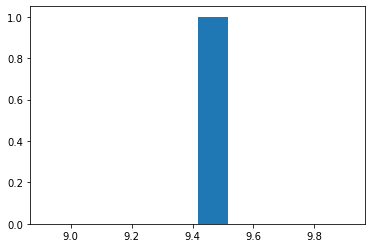

In [9]:
print(Varm2.values)
Varm2.plot()

In [10]:
# calculated various means of field VAR weighted by area and surface types
DS = xr.open_mfdataset(indir) #.chunk({'time': 20})
#print(DS)
weights = DS.area
weights.name = 'weights'
#print(weights)
#print(weights.sum(),4.*pi)
#Var = DS.FSNT.isel(time=0)
varname = 'FLNT'
LF = DS['LANDFRAC']
OF = DS['OCNFRAC']
IF = DS['ICEFRAC']
Var = DS[varname]
print ('over-riding Var values with one, to just calculated area and surface fractions')
Var = Var.where(weights.values < 0, other=1.)
Var.attrs["units"] = '1'
Var.attrs["long_name"] = 'Unit'
#print('xxx', weights,weights.values.min(),weights.values.max())
VG = Var.weighted(weights).mean()
VL = (Var*LF).weighted(weights).mean()/LF.weighted(weights).mean()
VO = (Var*OF).weighted(weights).mean()/OF.weighted(weights).mean()
VI = (Var*IF).weighted(weights).mean()/IF.weighted(weights).mean()

#print(varname,'units, min, mean over globe, then over masked regions, landmean, oceanmean, icemean, max, ',Var.attrs['units'],Var.values.min(),VG.values,VL.values,VO.values,VI.values,Var.values.max())

VG = Var.weighted(weights).mean()
VL = (Var*LF).weighted(weights).mean()
VO = (Var*OF).weighted(weights).mean()
VI = (Var*IF).weighted(weights).mean()


#print(varname,'units, min, Gavg, then averages over regions, landmean, oceanmean, icemean, max, ',Var.attrs['units'],Var.values.min(),VG.values,VL.values,VO.values,VI.values,Var.values.max())

# version 3, use sums to facilitate subregions
VL = (Var*LF*weights).sum()/weights.sum()
VO = (Var*OF*weights).sum()/weights.sum()
VI = (Var*IF*weights).sum()/weights.sum()

print('Global Land, Ocean, Sea-Ice values ',VL.values,VO.values,VI.values)

# extract a region
xleft = 0.; xright = 360; ymin = -30.; ymax = 0. # 25% of the globe
xleft = -170.; xright = -90.; ymin = -50.; ymax = -30. # S pacific
xleft = -110.; xright = -70.; ymin = -30.; ymax = 0. # SE Pacific
xleft = 360.-160.; xright = 360.-120.; ymin = 0.; ymax = 30. # NE Pacific
xleft = 360.-25.; xright = 15.; ymin = -30.; ymax = 0. # SE Atlantic
xleft = 360.-110.; xright = 360.-70.; ymin = -30.; ymax = 0. # SE Pacific
xleft = 160.; xright = -130.; ymin = 30.; ymax = 50. # N pacific

#print('dslat',DS['lat'])
lat = DS['lat'].values#[0,:]
#print('lat',lat)
#print('latshape',lat.shape)
#print('lat4',lat[0:3])
lon = DS['lon'].values#[0,:]
#print('lon4',lon[0:3])
#print('lat',lat.min(),lat.max())
#print('lon',lon.min(),lon.max())
#dist = np.abs(ylook-lat) + np.abs(xlook-lon)
#print('dist',dist)

# reset xleft, xright and lon so that they all use the same range
xleft = xleft%360.
xright = xright%360
if ((xleft > xright)):
    print ('Greenwich')
    xright = xright+360.
    i = np.where(lon < 180)
    lon[i] = lon[i]+360.
print ('xleft, xright', xleft, xright)
print ('lonrange', lon.min(), lon.max())

ind = np.where((lat >= ymin) & (lat <= ymax) & (lon >= xleft) & (lon <= xright))
#
#print('ind',ind)
print('latind',lat[ind].min(),lat[ind].max())
print('lonind',lon[ind].min(),lon[ind].max())

#print('x1 ', Var*LF*weights)
#print('x2 ', (Var*LF*weights).squeeze()[ind])

VL = (Var*LF*weights).squeeze()[ind].sum()/weights.sum()
VO = (Var*OF*weights).squeeze()[ind].sum()/weights.sum()
VI = (Var*IF*weights).squeeze()[ind].sum()/weights.sum()

print('regions (land, ocean, ice) fraction of total earth surface ',VL.values,VO.values,VI.values,VL.values+VO.values+VI.values)

VOO = (Var*OF*weights).squeeze()[ind].sum()/(Var*OF*weights).squeeze().sum()
print('V4 ocean region fraction of total ocean surface ',VOO.values)

#
#ind = int(ind[0])
#print('ind',ind, ind.shape, ind[0])
#print('ind',ind,lat[ind],lon[ind])

over-riding Var values with one, to just calculated area and surface fractions
Global Land, Ocean, Sea-Ice values  0.2917436540090094 0.6766178543171986 0.03163849168774253
xleft, xright 160.0 230.0
lonrange 0.7500003953503928 359.2499996046496
latind 30.070537541993843 49.96703342329517
lonind 160.4994221057124 229.90749268342665
regions (land, ocean, ice) fraction of total earth surface  0.0 0.025723528373120048 0.0 0.025723528373120048
V4 ocean region fraction of total ocean surface  0.038017809032069756


zmax, zmin 103203.43 54139.637
clevs [ 50000.  60000.  70000.  80000.  90000. 100000.]


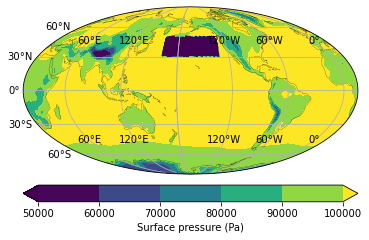

In [126]:

xi = np.linspace(0, 360, 721)  # to regrid to 1/2 degree
yi = np.linspace(-90, 90, 361)  # to regrid to 1/2 degree

data = DS['PS'].squeeze()
#data_regridded = griddata((lon, lat), data2d, (xi[None,:], yi[:,None]), method='linear')\
data2d = data.copy().squeeze()
zmax = data2d.max().values
zmin = data2d.min().values
print ('zmax, zmin', zmax, zmin)
data2d[ind] = 0.
data_regridded = interp_to_latlon(data2d.values,lat,lon,yi,xi)
df = data_regridded.flatten()
dsub = df[np.isfinite(df)] # ignore NaN

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
clon = (xleft+xright)/2.
#plotproj=ccrs.Orthographic(central_latitude=-0, central_longitude=clon)   # any projections should work 
plotproj=ccrs.Mollweide(central_longitude=clon)   # any projections should work 
#plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)
clevs = findNiceContours(np.array([zmin,zmax]),nlevs=5)
print('clevs',clevs)
pl = ax.contourf(xi, yi, data_regridded, clevs, vmin=zmin, vmax=zmax,  extend='both', transform=ccrs.PlateCarree())
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',ticks=clevs,
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=False)
xx = plt.show

In [14]:

inCmd='ncdump -v time '+indir+' | grep "FRAC.*="'
outCmd = os.popen(inCmd).read()
print(inCmd)
print(outCmd)

ncdump -v time /home/phil/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc | grep "FRAC.*="
		CLOUDFRAC_CLUBB:mdims = 1 ;
		CLOUDFRAC_CLUBB:units = "1" ;
		CLOUDFRAC_CLUBB:long_name = "Cloud Fraction" ;
		CLOUDFRAC_CLUBB:cell_methods = "time: mean" ;
		ICEFRAC:units = "1" ;
		ICEFRAC:long_name = "Fraction of sfc area covered by sea-ice" ;
		ICEFRAC:cell_methods = "time: mean" ;
		LANDFRAC:units = "1" ;
		LANDFRAC:long_name = "Fraction of sfc area covered by land" ;
		LANDFRAC:cell_methods = "time: mean" ;
		OCNFRAC:units = "1" ;
		OCNFRAC:long_name = "Fraction of sfc area covered by ocean" ;
		OCNFRAC:cell_methods = "time: mean" ;



In [15]:
T = DS.T
print(T)

<xarray.DataArray 'T' (time: 1, lev: 72, ncol: 21600)>
dask.array<open_dataset-e05a4d7a189eff4449e86c2283c40cd9T, shape=(1, 72, 21600), dtype=float32, chunksize=(1, 72, 21600), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * time     (time) object 0001-02-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_methods:   time: mean


plotting on eta levels


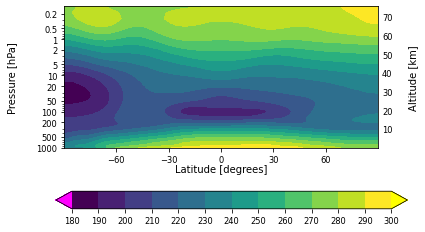

In [14]:
#DS = xr.open_dataset('~/NetCDF_Files/vd05_ANN_climo.nc')
#print (DS.T) 
T = DS.T.isel(time=0)
#T?
TZ = T.mean(dim='lon')
#TZ?
lev = TZ['lev']
lat = TZ['lat']
vals = TZ.values
print('plotting on eta levels')
plotZMf(vals, lat, lev)


In [15]:
# demonstrate shape specification to force correct broadcasting
# add a vector of numbers to a particular axis (in this case axis=1)
pout = np.arange(20)
x = np.zeros([2,20,100])
newshape = [1,20,1]
z = x + pout.reshape(newshape)
print('z shape', z.shape)
print(z[0,:,3])
print(z[1,:,-1])

z shape (2, 20, 100)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


In [16]:
# interpolate xarray datavariable on eta hybrid surfaces to pressure

indir = os.path.expanduser('~/NetCDF_Files/*F2010*.nc')
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#indir = os.path.expanduser('~/NetCDF_Files/*F2010*01.nc')
#indir = os.path.expanduser('~/NetCDF_Files/vd05_ANN_climo.nc')

print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})


    
Tin = DS.T
Tin = Tin.squeeze()
#print("Tin",Tin)
Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()
nzout = 20
pout = np.linspace(1.,1000.,nzout)
#pout = [850.]
#pout = 850.
#print ("pout", pout.shape, pout)

Tout = hy2plev(Tin, Pin, pout)


/home/phil/NetCDF_Files/*F2010*.nc


pjr3.py complete
plotting  <xarray.DataArray (ncol: 21600)>
array([285.35014074, 284.80348245, 286.31016305, ..., 264.18005051,
       264.78022066, 265.25982283])
Coordinates:
    time     object 0001-02-01 00:00:00
    plev     float64 850.0
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_methods:   time: mean


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

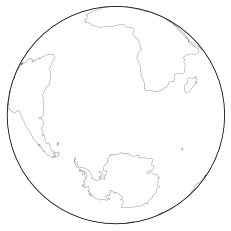

In [12]:
%run -i ~/Python/pjr3
from cartopy import crs

indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h0.2015-01.nc')
indir = os.path.expanduser('/home/phil/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc')

DS = xr.open_mfdataset(indir).chunk({'time': 20})
Tout = DS.PS.isel(time=0)
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#DS = xr.open_mfdataset(indir).chunk({'time': 20})
#Tout = DS.T850.isel(time=0)

gridfile = '/lustre/d3x345/maps/ne30pg2_scrip_c20191218.nc'

Tin = DS.T
Tin = Tin.squeeze()
#print("Tin",Tin)
Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()
pout = 850.

Tout2 = hy2plev(Tin, Pin, pout).squeeze()

# Read data
data = Tout2
print('plotting ', data)

lon = DS['lon']
lat = DS['lat']

dataproj=crs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=crs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
data2d = data
xi=tcoords[:,0]!=np.inf
tc=tcoords[xi,:]
datai=data2d[:][xi]  # convert to numpy array, then subset
dmin = datai.min().values
dmax = datai.max().values
pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud',vmin=dmin,vmax=dmax) # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
plt.show

In [13]:
# plot a column specified by xlook and ylook for fields specified on a cubed sphere grid
xlook = 0.
ylook = -90.
lat = DS['lat'].values#[0,:]
#print('latshape',lat.shape)
#print('lat4',lat[0:3])
lon = DS['lon'].values#[0,:]
#print('lon4',lon[0:3])
#print('lat',lat.min(),lat.max())
#print('lon',lon.min(),lon.max())
dist = np.abs(ylook-lat) + np.abs(xlook-lon)
#print('dist',dist)
ind = np.where(dist == np.min(dist))
ind = int(ind[0])
#print('ind',ind, ind.shape, ind[0])
print('ind',ind,lat[ind],lon[ind])
#print('Tout', Tout.shape, Tout.squeeze().shape)
#Toutm = Tout.mean(dim=['ncol','time'])
#Tinm = Tin[0,:,ind]
#print('Tinm',Tinm.values)
#Pinm = Pin[0,:,ind]
#print('Pinm',Pinm.values)
#tind = 0
#for index, item in enumerate(Pinm):
#    print('Pinx ',index, Pinm[index].values, Tinm[index].values)
Toutm = Tout[:,ind]
#print('Toutm',Toutm)
#for index, item in enumerate(Toutm):
#    print('Poutx ',index, pout[index], Toutm[index].values)

Toutm.plot()

ind 16500 -83.20921924057815 6.311501752522137


IndexError: too many indices

In [ ]:
ToutZ = Tout.mean(dim='lon')
lev = ToutZ['plev']
lat = ToutZ['lat']
vals = ToutZ.values
plotZMf(vals, lat, lev)

In [ ]:
da = DS.PS# Draw coastlines of the Earth
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines() 



da.plot()
plt.show()

In [ ]:
TS = DS.TS# Draw coastlines of the Earth
TS = TS.isel(time=0)
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
lon = TS['lon']
lat = TS['lat']
ax.contourf(lon, lat, TS, transform=ccrs.PlateCarree())

da.plot()
plt.show()

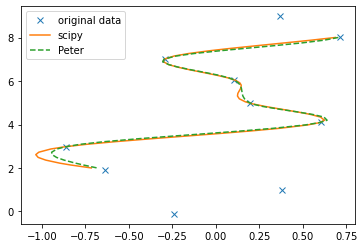

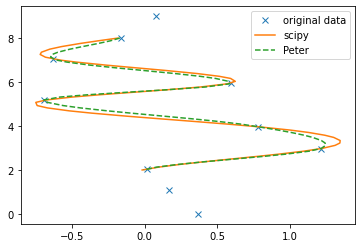

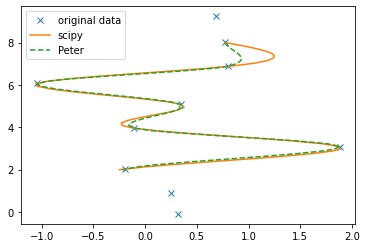

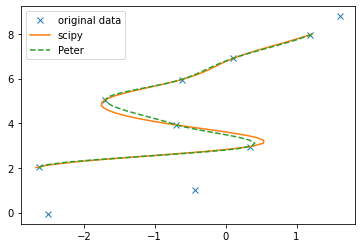

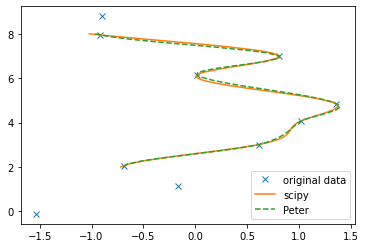

In [21]:
# fast 1d interpolation of fields along an axis
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d as scipy1d

# toy coordinates and data
nx, ny, nz = 25, 30, 10
x = np.arange(nx)
y = np.arange(ny)
z = np.tile(np.arange(nz), (nx,ny,1)) + np.random.randn(nx, ny, nz)*.1
testdata = np.random.randn(nx,ny,nz) # x,y,z

# Desired z-coordinates (must be between bounds of z)
znew = np.tile(np.linspace(2,nz-2,50), (nx,ny,1)) + np.random.randn(nx, ny, 50)*0.01

# Inverse the coordinates for testing
z = z[..., ::-1]
znew = znew[..., ::-1]

# Now use own routine 
ynew = interp_along_axis(testdata, z, znew, axis=2, inverse=True, method='cubic')

# Check some random profiles
for i in range(5):
    randx = np.random.randint(nx)
    randy = np.random.randint(ny)

    checkfunc = scipy1d(z[randx, randy], testdata[randx,randy], kind='cubic')
    checkdata = checkfunc(znew)

    fig, ax = plt.subplots()
    ax.plot(testdata[randx, randy], z[randx, randy], 'x', label='original data')
    ax.plot(checkdata[randx, randy], znew[randx, randy], label='scipy')
    ax.plot(ynew[randx, randy], znew[randx, randy], '--', label='Peter')
    ax.legend()
    plt.show()
